In [238]:
#Install uninstalled modules, comment if it's already installed

#%pip install -U MetaTrader5 matplotlib numpy pandas pandas_ta pickle scikit-learn

In [239]:
#Python version
!python --version

Python 3.8.12


In [240]:
#Import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from finta import TA

from datetime import datetime
import os, pytz
import MetaTrader5 as mt5

import config

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle

In [241]:
#HYPER PARAMETER

In [242]:
#Trading Account Parameter
account = config.username   #Account number
password = config.password  #Password number
server = config.mt5_server  #Server name
path = config.mt5_path      #path of Metatrader5 director

mt5.initialize(
   path = path,          # path to the MetaTrader 5 terminal EXE file
   login = account,      # account number
   password = password,  # password
   server = server,      # server name as it is specified in the terminal
   #timeout = TIMEOUT,   # timeout
   portable = False      # portable mode
   )

# display data on the MetaTrader 5 package
print("MetaTrader5 package author: ",mt5.__author__)
print("MetaTrader5 package version: ",mt5.__version__,"\n")

# establish connection to the MetaTrader 5 terminal
if not mt5.initialize():
    print("initialize failed, error code =",mt5.last_error())
    mt5.shutdown()
else:
    print("MetaTrader5 Initialized!")
    account_info_dict = mt5.account_info()._asdict()
    Acc_Info = pd.DataFrame(list(account_info_dict.items()),columns=['property','value'])
    print("\n", "account_info() as dataframe:")
    print(Acc_Info)

MetaTrader5 package author:  MetaQuotes Ltd.
MetaTrader5 package version:  5.0.36 

MetaTrader5 Initialized!

 account_info() as dataframe:
              property             value
0                login            647479
1           trade_mode                 0
2             leverage              1000
3         limit_orders               100
4       margin_so_mode                 0
5        trade_allowed              True
6         trade_expert              True
7          margin_mode                 2
8      currency_digits                 2
9           fifo_close             False
10             balance          99994.96
11              credit               0.0
12              profit               0.0
13              equity          99994.96
14              margin               0.0
15         margin_free          99994.96
16        margin_level               0.0
17      margin_so_call              40.0
18        margin_so_so              20.0
19      margin_initial               0.0

In [243]:
# set time zone to UTC
timezone = pytz.timezone("Etc/UTC")
symbol = 'EURUSD'
timeframe = mt5.TIMEFRAME_M5
bars = 50000

rates = mt5.copy_rates_from_pos(symbol, timeframe, 1, bars + 1)

# create DataFrame out of the obtained data
rates_frame = pd.DataFrame(rates, dtype=np.dtype("float"))

# convert time in seconds into the datetime format
rates_frame['time']=pd.to_datetime(rates_frame['time'], unit='s')
rates_frame = rates_frame.rename(columns={'tick_volume': 'volume'})
del rates_frame['real_volume']

rates_frame = rates_frame.set_index('time')                           

# display data
print("\nDisplay dataframe with data")
rates_frame.tail()


Display dataframe with data


,open,high,low,close,volume,spread
time,,,,,,
2022-01-07 19:15:00,1.13538,1.13561,1.13532,1.13558,114.0,10.0
2022-01-07 19:20:00,1.13558,1.13572,1.13546,1.13546,118.0,10.0
2022-01-07 19:25:00,1.13546,1.13560,1.13541,1.13558,54.0,10.0
2022-01-07 19:30:00,1.13558,1.13558,1.13526,1.13533,64.0,10.0
2022-01-07 19:35:00,1.13533,1.13541,1.13509,1.13516,109.0,10.0


In [244]:
symbol_info = mt5.symbol_info(symbol)
if symbol_info!=None:
    # display the terminal data 'as is'    
    #print(symbol_info)
    print("\n","{}:".format(symbol))
    print("spread =",symbol_info.spread,", digits =",symbol_info.digits, "\n")
    print(symbol_info.swap_long, '\n')
    print ("------------------------------")
else:
    print("There is no such symbol of {}".format(symbol))


 EURUSD:
spread = 12 , digits = 5 

-6.37 

------------------------------


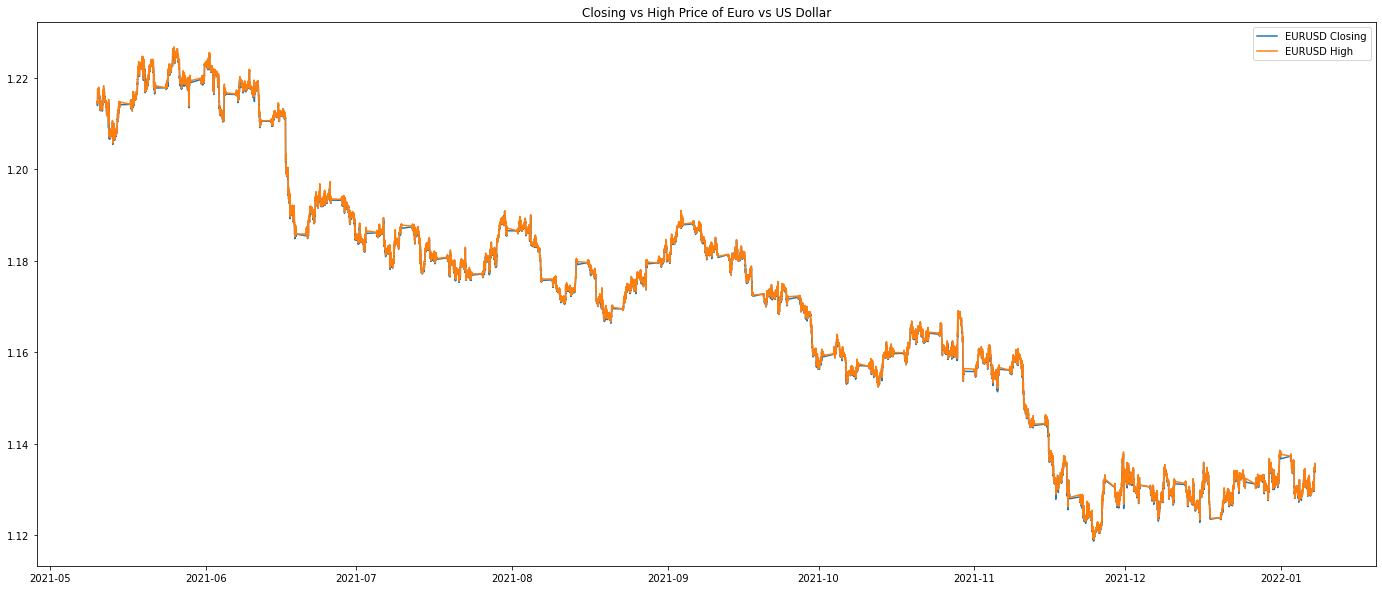

In [245]:
def plotClosing(df):
    plt.figure(figsize=(24,10))
    plt.plot(df.close, label='{} Closing'.format(symbol))
    plt.plot(df.high, label='{} High'.format(symbol))
    plt.title('Closing vs High Price of {}'.format(symbol_info.description))
    plt.legend()
    plt.show()

plotClosing(rates_frame)

In [246]:
def generate_features(df):
    """ Generate features for a stock/index/currency/commodity based on historical price and performance
    Args:
        df (dataframe with columns "open", "close", "high", "low", "volume")
    Returns:
        dataframe, data set with new features
    """
    df_new = pd.DataFrame()
    
    # 6 original features
    df_new['open'] = df['open']
    df_new['open_1'] = df['open'].shift(1)
    df_new['close_1'] = df['close'].shift(1)
    df_new['high_1'] = df['high'].shift(1)
    df_new['low_1'] = df['low'].shift(1)
    df_new['volume_1'] = df['volume'].shift(1)
    df_new['spread_1'] = df['spread'].shift(1)
    
    # 50 original features
    # average price
    df_new['avg_price_5'] = df['close'].rolling(window=5).mean().shift(1)
    df_new['avg_price_30'] = df['close'].rolling(window=21).mean().shift(1)
    df_new['avg_price_90'] = df['close'].rolling(window=63).mean().shift(1)
    df_new['avg_price_365'] = df['close'].rolling(window=252).mean().shift(1)
    
    # average price ratio
    df_new['ratio_avg_price_5_30'] = df_new['avg_price_5'] / df_new['avg_price_30']
    df_new['ratio_avg_price_5_90'] = df_new['avg_price_5'] / df_new['avg_price_90']
    df_new['ratio_avg_price_5_365'] = df_new['avg_price_5'] / df_new['avg_price_365']
    df_new['ratio_avg_price_30_90'] = df_new['avg_price_30'] / df_new['avg_price_90']
    df_new['ratio_avg_price_30_365'] = df_new['avg_price_30'] / df_new['avg_price_365']
    df_new['ratio_avg_price_90_365'] = df_new['avg_price_90'] / df_new['avg_price_365']                                            
    
    
    # average volume
    df_new['avg_volume_5'] = df['volume'].rolling(window=5).mean().shift(1)
    df_new['avg_volume_30'] = df['volume'].rolling(window=21).mean().shift(1)
    df_new['avg_volume_90'] = df['volume'].rolling(window=63).mean().shift(1)
    df_new['avg_volume_365'] = df['volume'].rolling(window=252).mean().shift(1)
    
    # average volume ratio
    df_new['ratio_avg_volume_5_30'] = df_new['avg_volume_5'] / df_new['avg_volume_30']
    df_new['ratio_avg_volumee_5_90'] = df_new['avg_volume_5'] / df_new['avg_volume_90']                                                   
    df_new['ratio_avg_volume_5_365'] = df_new['avg_volume_5'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_30_90'] = df_new['avg_volume_30'] / df_new['avg_volume_90']
    df_new['ratio_avg_volume_30_365'] = df_new['avg_volume_30'] / df_new['avg_volume_365']
    df_new['ratio_avg_volume_90_365'] = df_new['avg_volume_90'] / df_new['avg_volume_365']                                                 
    
    
    # standard deviation of prices
    df_new['std_price_5'] = df['close'].rolling(window=5).std().shift(1)
    df_new['std_price_30'] = df['close'].rolling(window=21).std().shift(1)
    df_new['std_price_90'] = df['close'].rolling(window=63).std().shift(1)                                               
    df_new['std_price_365'] = df['close'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of prices 
    df_new['ratio_std_price_5_30'] = df_new['std_price_5'] / df_new['std_price_30']
    df_new['ratio_std_price_5_90'] = df_new['std_price_5'] / df_new['std_price_90']
    df_new['ratio_std_price_5_365'] = df_new['std_price_5'] / df_new['std_price_365']
    df_new['ratio_std_price_30_90'] = df_new['std_price_30'] / df_new['std_price_90'] 
    df_new['ratio_std_price_30_365'] = df_new['std_price_30'] / df_new['std_price_365']                                               
    df_new['ratio_std_price_90_365'] = df_new['std_price_90'] / df_new['std_price_365']                                                
    
    
    # standard deviation of volumes
    df_new['std_volume_5'] = df['volume'].rolling(window=5).std().shift(1)
    df_new['std_volume_30'] = df['volume'].rolling(window=21).std().shift(1)
    df_new['std_volume_90'] = df['volume'].rolling(window=63).std().shift(1)
    df_new['std_volume_365'] = df['volume'].rolling(window=252).std().shift(1)
    
    # standard deviation ratio of volumes
    df_new['ratio_std_volume_5_30'] = df_new['std_volume_5'] / df_new['std_volume_30']
    df_new['ratio_std_volume_5_90'] = df_new['std_volume_5'] / df_new['std_volume_90']
    df_new['ratio_std_volume_5_365'] = df_new['std_volume_5'] / df_new['std_volume_365']                                               
    df_new['ratio_std_volume_30_90'] = df_new['std_volume_30'] / df_new['std_volume_90']
    df_new['ratio_std_volume_30_365'] = df_new['std_volume_30'] / df_new['std_volume_365']
    df_new['ratio_std_volume_90_365'] = df_new['std_volume_90'] / df_new['std_volume_365']                                               
                                                   
    # return
    df_new['return_1'] = ((df['close'] - df['close'].shift(1)) / df['close'].shift(1)).shift(1)
    df_new['return_5'] = ((df['close'] - df['close'].shift(5)) / df['close'].shift(5)).shift(1)
    df_new['return_30'] = ((df['close'] - df['close'].shift(21)) / df['close'].shift(21)).shift(1)
    df_new['return_90'] = ((df['close'] - df['close'].shift(63)) / df['close'].shift(63)).shift(1)                                                
    df_new['return_365'] = ((df['close'] - df['close'].shift(252)) / df['close'].shift(252)).shift(1)
    
    # average of return
    df_new['moving_avg_5'] = df_new['return_1'].rolling(window=5).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=21).mean()
    df_new['moving_avg_30'] = df_new['return_1'].rolling(window=63).mean()
    df_new['moving_avg_365'] = df_new['return_1'].rolling(window=252).mean()

    # technical indicators
    df_new['AO14_1'] = TA.AO(df, 14).shift(1)
    df_new['RSI14_1'] = TA.RSI(df, 14).shift(1)

    # the target
    df_new['close'] = df['close']
    df_new = df_new.dropna(axis=0)
    return df_new

df = generate_features(rates_frame)
df.tail()

,open,open_1,close_1,high_1,low_1,volume_1,spread_1,avg_price_5,avg_price_30,avg_price_90,...,return_5,return_30,return_90,return_365,moving_avg_5,moving_avg_30,moving_avg_365,AO14_1,RSI14_1,close
time,,,,,,,,,,,,,,,,,,,,,
2022-01-07 19:15:00,1.13538,1.13488,1.13540,1.13545,1.13487,116.0,10.0,1.135192,1.134522,1.132293,...,0.000626,0.000626,0.004477,0.005428,0.000125,0.000071,0.000022,0.000520,64.908514,1.13558
2022-01-07 19:20:00,1.13558,1.13538,1.13558,1.13561,1.13532,114.0,10.0,1.135336,1.134580,1.132378,...,0.000634,0.001058,0.004707,0.005971,0.000127,0.000075,0.000024,0.000593,66.405922,1.13546
2022-01-07 19:25:00,1.13546,1.13558,1.13546,1.13572,1.13546,118.0,10.0,1.135318,1.134657,1.132462,...,-0.000079,0.001429,0.004672,0.005811,-0.000016,0.000074,0.000023,0.000589,64.431985,1.13558
2022-01-07 19:30:00,1.13558,1.13546,1.13558,1.13560,1.13541,54.0,10.0,1.135378,1.134749,1.132551,...,0.000264,0.001702,0.005000,0.005891,0.000053,0.000079,0.000023,0.000509,65.535266,1.13533
2022-01-07 19:35:00,1.13533,1.13558,1.13533,1.13558,1.13526,64.0,10.0,1.135470,1.134819,1.132638,...,0.000405,0.001296,0.004841,0.005633,0.000081,0.000077,0.000022,0.000457,61.271178,1.13516


In [247]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49748 entries, 2021-05-11 07:45:00 to 2022-01-07 19:35:00
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   open                     49748 non-null  float64
 1   open_1                   49748 non-null  float64
 2   close_1                  49748 non-null  float64
 3   high_1                   49748 non-null  float64
 4   low_1                    49748 non-null  float64
 5   volume_1                 49748 non-null  float64
 6   spread_1                 49748 non-null  float64
 7   avg_price_5              49748 non-null  float64
 8   avg_price_30             49748 non-null  float64
 9   avg_price_90             49748 non-null  float64
 10  avg_price_365            49748 non-null  float64
 11  ratio_avg_price_5_30     49748 non-null  float64
 12  ratio_avg_price_5_90     49748 non-null  float64
 13  ratio_avg_price_5_365    49748 non-null  

In [248]:
X = df.drop('close', axis='columns')
y = df.close

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(34823, 57)
(14925, 57)
(34823,)
(14925,)


In [249]:
#initiating standard scaler
scaler = StandardScaler()

#fit the scaler in training features
scaler.fit(X_train)

#Rescale both sets using the trained scaler
X_scaled_train = scaler.transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [250]:
lin = LinearRegression()

lin.fit(X_scaled_train, y_train)
predictions_lin = lin.predict(X_scaled_test)

'''
Score Criteria:
    RMSE = closer to 0.0 the better
    MAE = closer to 0.0 the better, there is no negative point
    R^2 = closer to 1.0 the better, if negative it means the model is very bad
'''

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, predictions_lin)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, predictions_lin)))
print('R^2: {0:.3f}'.format(r2_score(y_test, predictions_lin)))

RMSE: 0.000
MAE: 0.000
R^2: 0.999


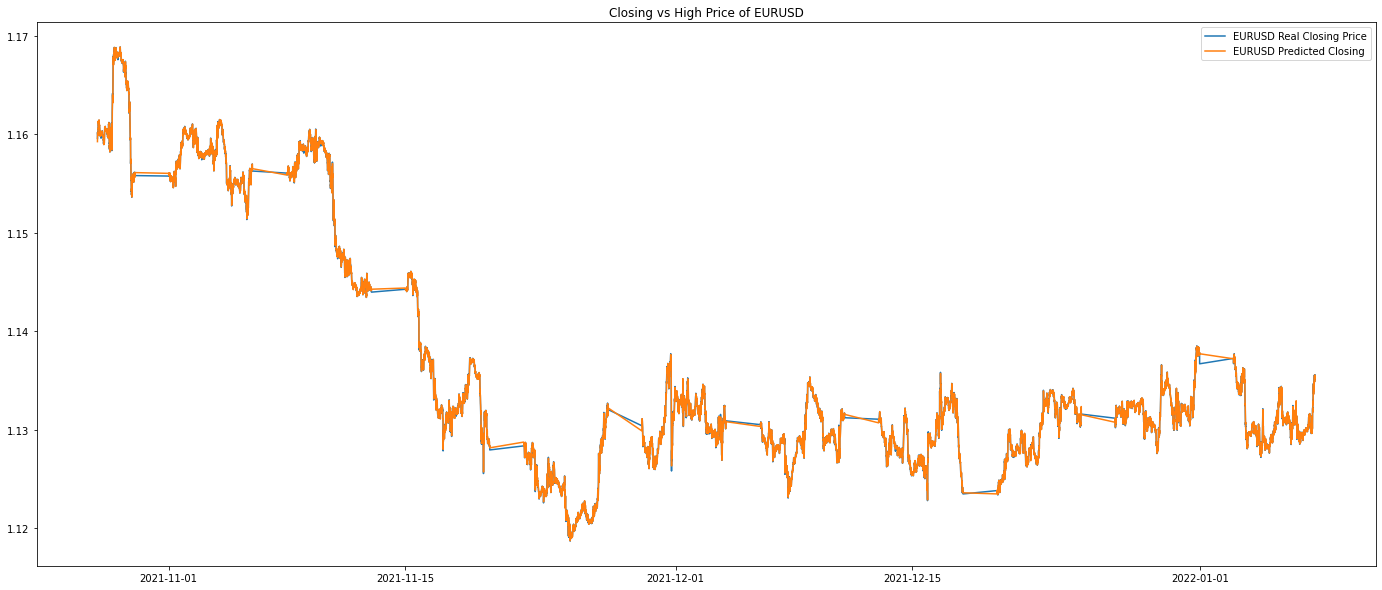

In [251]:
def plotLinearReg(y_test, predictions):
    predictions = pd.DataFrame(predictions, index=y_test.index)
    plt.figure(figsize=(24,10))
    plt.plot(y_test, label='{} Real Closing Price'.format(symbol))
    plt.plot(predictions, label='{} Predicted Closing'.format(symbol))
    plt.title('Closing vs High Price of {}'.format(symbol))
    plt.legend()
    plt.show()

plotLinearReg(y_test, predictions_lin)

In [252]:
def generate_resultdf(y_test, prediction):
    df_pred = pd.DataFrame()
    df_pred['close'] = y_test
    df_pred['predicted'] = predictions_lin
    df_pred['close diff'] = df_pred['close'] - df_pred['close'].shift(1)
    df_pred['predicted diff'] = df_pred['predicted'] - df_pred['predicted'].shift(1)
    df_pred['close-pred diff'] = df_pred['close'] - df_pred['predicted']
    df_pred['high'] = rates_frame['high']

    return df_pred

df_pred = generate_resultdf(y_test, predictions_lin)
df_pred.tail()

,close,predicted,close diff,predicted diff,close-pred diff,high
time,,,,,,
2022-01-07 19:15:00,1.13558,1.135336,0.00018,0.000454,0.000244,1.13561
2022-01-07 19:20:00,1.13546,1.135534,-0.00012,0.000198,-0.000074,1.13572
2022-01-07 19:25:00,1.13558,1.135428,0.00012,-0.000106,0.000152,1.13560
2022-01-07 19:30:00,1.13533,1.135538,-0.00025,0.000110,-0.000208,1.13558
2022-01-07 19:35:00,1.13516,1.135307,-0.00017,-0.000231,-0.000147,1.13541


In [253]:
filename = 'saved_model/MetaNgepet_{}_{}_LinearReg.sav'.format(symbol, timeframe)
pickle.dump(lin, open(filename, 'wb'))

In [254]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))

model_prediction = loaded_model.predict(X_scaled_test)

print('RMSE: {0:.3f}'.format(mean_squared_error(y_test, model_prediction)**0.5))
print('MAE: {0:.3f}'.format(mean_absolute_error(y_test, model_prediction)))
print('R^2: {0:.3f}'.format(r2_score(y_test, model_prediction)))

RMSE: 0.000
MAE: 0.000
R^2: 0.999


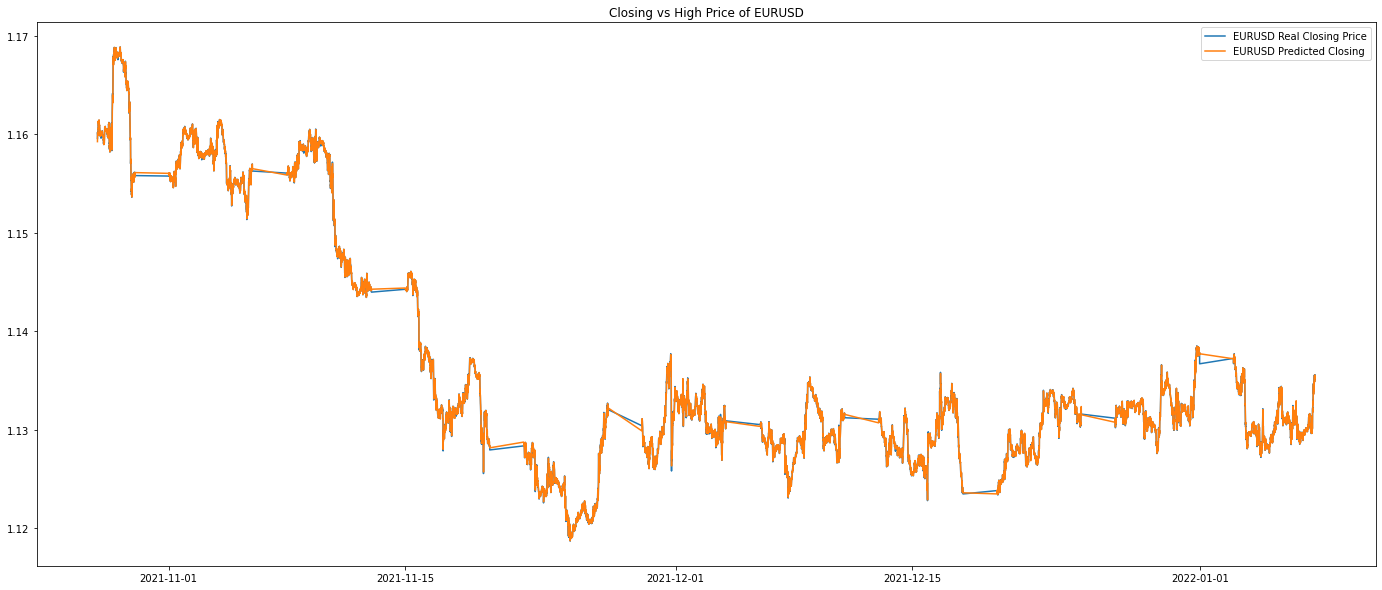

In [255]:
plotLinearReg(y_test, model_prediction)

In [256]:
df_model = generate_resultdf(y_test, model_prediction)
df_model.tail()

,close,predicted,close diff,predicted diff,close-pred diff,high
time,,,,,,
2022-01-07 19:15:00,1.13558,1.135336,0.00018,0.000454,0.000244,1.13561
2022-01-07 19:20:00,1.13546,1.135534,-0.00012,0.000198,-0.000074,1.13572
2022-01-07 19:25:00,1.13558,1.135428,0.00012,-0.000106,0.000152,1.13560
2022-01-07 19:30:00,1.13533,1.135538,-0.00025,0.000110,-0.000208,1.13558
2022-01-07 19:35:00,1.13516,1.135307,-0.00017,-0.000231,-0.000147,1.13541
